In [1]:
import numpy as np
import pandas as pd
import pegasus as pg
import json
import os
import pegasusio
from pegasusio import UnimodalData, MultimodalData
import matplotlib.pyplot as plt 
import scipy.sparse
import matplotlib.patches as mpatches
import itertools
from matplotlib import cm
import scanpy as sc
from matplotlib.pyplot import rc_context
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import mannwhitneyu
from utils.lists import *
from utils.plot_utils import *

2024-06-26 11:33:52.219344: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 11:33:52.221704: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 11:33:52.263503: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 11:33:52.265793: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 11:33:53.184370: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Fig. 1b RNA UMAP and Cell Proportions

In [2]:
data = pg.read_input('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/RNA_FINAL.zarr')
data

2023-11-01 14:21:28,334 - pegasusio.readwrite - INFO - zarr file '/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/RNA_FINAL.zarr' is loaded.
2023-11-01 14:21:28,336 - pegasusio.readwrite - INFO - Function 'read_input' finished in 340.50s.


MultimodalData object with 1 UnimodalData: 'GRCh38-rna'
    It currently binds to UnimodalData object GRCh38-rna

UnimodalData object with n_obs x n_vars = 935371 x 27982
    Genome: GRCh38; Modality: rna
    It contains 2 matrices: 'X', 'raw.X'
    It currently binds to matrix 'X' as X

    obs: 'n_genes', 'n_counts', 'percent_mito', 'doublet', 'doublet_score', 'Channel', 'scale', 'leiden_labels'(cluster), 'hodge_anno', 'lake_anno', 'nenad_anno', 'fine_anno', 'subclass', 'class', 'BrNum', 'Condition', 'Sex', 'Smoking', 'Antidepressant', 'PMI', 'RIN', 'Race', 'AgeDeath', 'subclass2', 'subclass_renamed', 'subclass_final'
    var: 'featureid', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'(basis), 'pca_harmony_knn_distances'(knn), 'pca_harmony_knn_indices'(knn)
    varm: 'means', 'partial_sum', 'de_res'
    obsp: 'W_pca_harmony'
    uns: 'genome', 'leiden_resolution', 'modality', 'norm_

In [12]:
ann = sc.AnnData(data.X)
ann.var_names = data.var_names
ann.obs_names = data.obs_names

In [13]:
ann.obs['Subclass'] = data.obs['subclass_renamed']
ann.obsm['umap'] = data.obsm['X_umap']

In [17]:
colors = [subclass_colors[x] for x in ann.obs.Subclass.cat.categories]

/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


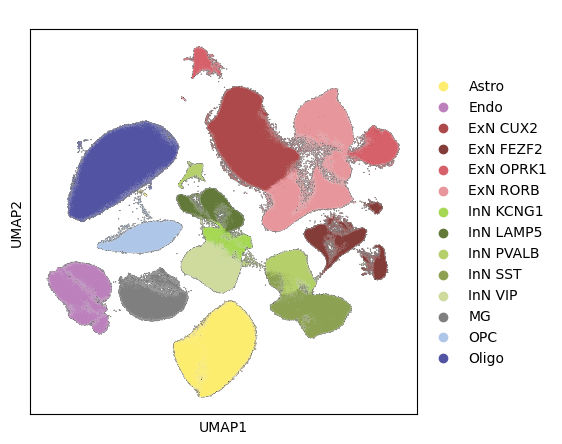

In [20]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(ann, color='Subclass', size=1, add_outline=True,palette=colors,save='_rna_no_labels.pdf',title=' ')

In [118]:
meta = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/RNA/data/RNA_FINAL_meta.csv',sep='\t')

In [143]:
arr = np.zeros((3,14))
for ii,cond in enumerate(['CON','MDD','PTSD']):
    x = meta[meta.Condition==cond].subclass_renamed.value_counts()/meta[meta.Condition==cond].subclass_renamed.value_counts().sum()
    x = x.reindex(['CUX2','RORB','FEZF2','OPRK1','LAMP5','KCNG1','VIP','SST','PVALB','ODC','OPC','END','ASC','MG'])
    print(x.values)
    arr[ii] = x.values

[0.15686969 0.13306651 0.03720404 0.03664527 0.02320867 0.01382319
 0.03738272 0.04513411 0.03545625 0.20486589 0.05664423 0.03168451
 0.14294254 0.04507238]
[0.16041701 0.13224471 0.03805245 0.03851558 0.02366385 0.01397273
 0.0385975  0.04648335 0.04070522 0.214468   0.05209764 0.03910159
 0.12082393 0.04085645]
[0.1872604  0.12740246 0.03382546 0.03402536 0.02454288 0.01545699
 0.04160232 0.04532308 0.03928409 0.16085391 0.05749458 0.04179899
 0.15123924 0.03989025]


In [145]:
df = pd.DataFrame(arr)
df.index = ['CON','MDD','PTSD']
df.columns = ['CUX2','RORB','FEZF2','OPRK1','LAMP5','KCNG1','VIP','SST','PVALB','ODC','OPC','END','ASC','MG']
df = df.reindex(['PTSD','MDD','CON'])

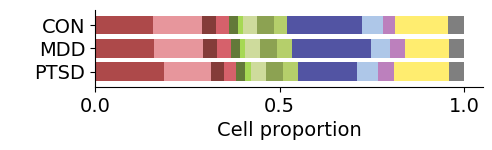

In [151]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots()
df.plot(stacked=True,kind='barh',color=[subclass_colors[c] for c in df.columns],figsize=(5,1),width=0.8,legend=None, ax=ax)
ax.set_xlabel('Cell proportion')
ax.set_xticks([0,0.5,1])
ax.set_ylabel(' ')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('/home/ah2428/figs/rna_proportions.pdf',bbox_inches='tight')

# Fig. 1c ATAC UMAP and Cell Proportions

In [4]:
atac = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/atac_umap.txt',sep='\t')
atac_meta = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/ATAC/data/ATAC_FINAL_meta.csv',sep='\t')
atac['Celltype'] = atac_meta['Int_Cluster'].values

In [5]:
atac['Celltype'] = atac['Celltype'].astype('category')

In [6]:
ann = sc.AnnData(np.empty((473033,2)))

In [7]:
ann.obs_names = atac.index

In [8]:
ann.obs['Celltype'] = atac['Celltype']

In [9]:
ann.obsm['umap'] = np.array(atac[['umap1','umap2']])

In [11]:
colors = [class_colors2[x] for x in ann.obs.Celltype.cat.categories]

/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


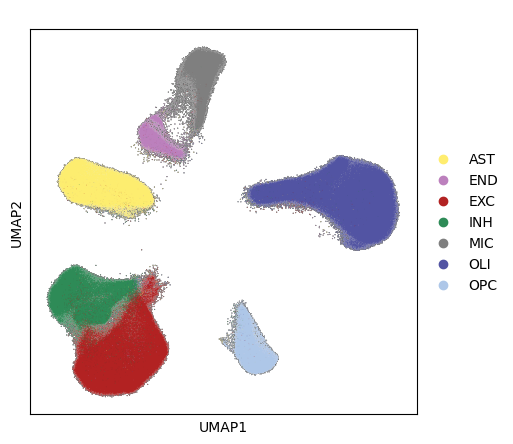

In [12]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(ann, color='Celltype', size=1, add_outline=True,palette=colors,save='_atac_no_labels.pdf',title=' ')

In [107]:
meta = atac_meta
arr = np.zeros((3,7))
for ii,cond in enumerate(['CON','MDD','PTSD']):
    print(cond)
    x = meta[meta.Condition==cond]['Int_Cluster'].value_counts()/meta[meta.Condition==cond]['Int_Cluster'].value_counts().sum()
    x = x.reindex(['EXC','INH','OLI','OPC','END','AST','MIC'])
    arr[ii] = x.values

CON
MDD
PTSD


In [108]:
df = pd.DataFrame(arr)
df.index = ['CON','MDD','PTSD']
df.columns = ['EXN','INH','ODC','OPC','END','ASC','MG']
df = df.reindex(['PTSD','MDD','CON'])

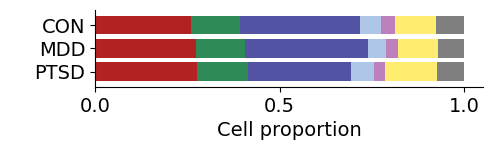

In [114]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
fig, ax = plt.subplots()

colors = [class_colors[x] for x in df.columns]
df.plot(stacked=True,kind='barh',color=colors,figsize=(5,1),width=0.8,legend=None, ax=ax)
ax.set_xlabel('Cell proportion')
ax.set_xticks([0,0.5,1])
ax.set_ylabel(' ')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

    
plt.savefig('/home/ah2428/figs/atac_proportions.pdf',bbox_inches='tight',dpi=300)

# Fib. 1d Multiome UMAP and Cell Proportions

In [81]:
meta = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/Multiome/data/MULTIOME_FINAL_meta.csv',sep='\t')

In [82]:
umap = pd.read_csv('/gpfs/gibbs/pi/gerstein/jz435/ShareZhangLab/PTSD/Multiome/data/multiome_umap.csv',sep=',',index_col=0)

In [83]:
ann = sc.AnnData(np.empty((umap.shape[0],2)))
ann.obs_names = umap.index
ann.obsm['umap'] = np.array(umap[['umap1','umap2']])

In [84]:
ann.obs['subclass'] = meta['subclass'].values
ann.obs['subclass'] = ann.obs['subclass'].astype('category')

In [87]:
colors = [subclass_colors[x] for x in ann.obs.subclass.cat.categories]

/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/gpfs/gibbs/project/gerstein/ah2428/conda_envs/RNA/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


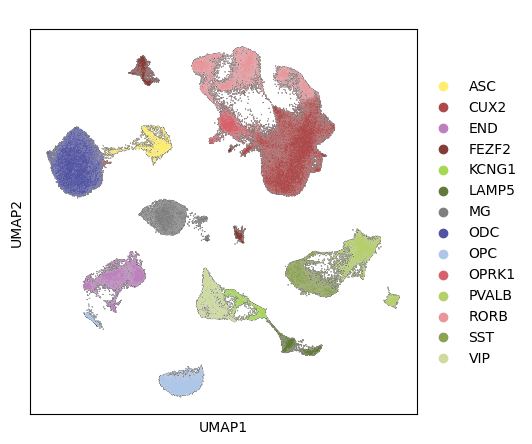

In [76]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(ann, color='subclass', size=1, add_outline=True, palette=colors,save='_multiome_no_labels.pdf',title=' ')

In [171]:
#meta = data.obs
arr = np.zeros((3,14))
for ii,cond in enumerate(['CON','MDD','PTSD']):
    print(cond)
    x = meta[meta.Condition==cond].subclass.value_counts()/meta[meta.Condition==cond].subclass.value_counts().sum()
    x = x.reindex(['ExN CUX2','ExN RORB','ExN FEZF2','ExN OPRK1','InN LAMP5','InN KCNG1','InN VIP','InN SST','InN PVALB','Oligo','OPC','Endo','Astro','MG'])
    print(x.values)
    arr[ii] = x.values

CON
[0.22020295 0.11346863 0.03376384 0.03530904 0.02022601 0.01845018
 0.04112085 0.04734779 0.05765683 0.18023524 0.074631   0.05961716
 0.02859779 0.06937269]
MDD
[0.30221519 0.13117842 0.01808318 0.0255425  0.02373418 0.01717902
 0.05801688 0.06781193 0.06871609 0.10232068 0.06133213 0.045434
 0.0287824  0.04965341]
PTSD
[0.28431981 0.0995398  0.02614691 0.03466616 0.02275514 0.01995255
 0.04557397 0.04555805 0.06312202 0.12969952 0.06248507 0.07011258
 0.03605153 0.06001688]


In [172]:
df = pd.DataFrame(arr)
df.index = ['CON','MDD','PTSD']
df.columns = ['CUX2','RORB','FEZF2','OPRK1','LAMP5','KCNG1','VIP','SST','PVALB','ODC','OPC','END','ASC','MG']

In [173]:
df = df.reindex(['PTSD','MDD','CON'])

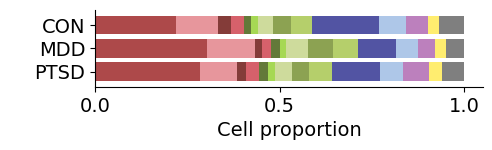

In [175]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots()
df.plot(stacked=True,kind='barh',color=[subclass_colors[x] for x in df.columns],figsize=(5,1),width=0.8,legend=None, ax=ax)
ax.set_xlabel('Cell proportion')
ax.set_xticks([0,0.5,1])
ax.set_ylabel(' ')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('/home/ah2428/figs/multiome_proportions.pdf',bbox_inches='tight',dpi=300)

# Fig. 1e RNA marker genes heatmap

In [3]:
import anndata
from pegasusio import UnimodalData, MultimodalData
from pandas.api.types import is_numeric_dtype, is_categorical_dtype, is_list_like

from typing import List, Tuple, Union, Optional, Callable
from pegasus.tools import X_from_rep, slicing

import logging
logger = logging.getLogger(__name__)
import seaborn as sns

def heatmap(
    data: Union[MultimodalData, UnimodalData, anndata.AnnData],
    attrs: Union[str, List[str]],
    groupby: str,
    matkey: Optional[str] = None,
    on_average: bool = True,
    switch_axes: bool = False,
    attrs_cluster: Optional[bool] = False,
    attrs_dendrogram: Optional[bool] = True,
    groupby_cluster: Optional[bool] = True,
    groupby_dendrogram: Optional[bool] = True,
    attrs_labelsize: Optional[float] = 10.0,
    groupby_labelsize: Optional[float] = 10.0,
    cbar_labelsize: Optional[float] = 8.0,
    panel_size: Tuple[float, float] = (10, 10),
    return_fig: Optional[bool] = False,
    dpi: Optional[float] = 300.0,
    **kwargs,
) -> Union[plt.Figure, None]:
    """
    Generate a heatmap.

    Parameters
    -----------

    data: ``AnnData`` or ``MultimodalData`` or ``UnimodalData`` object
        Single-cell expression data.
    attrs: ``str`` or ``List[str]``
        Cell attributes or features to plot.
        Cell attributes must exist in ``data.obs`` and must be numeric.
        Features must exist in ``data.var``.
        By default, attrs are plotted as columns.
    groupby: ``str``
        A categorical variable in data.obs that is used to categorize the cells, e.g. Clusters.
        By default, data.obs['groupby'] is plotted as rows.
    matkey: ``str``, optional, default: ``None``
        If matkey is set, select matrix with matkey as keyword in the current modality. Only works for MultimodalData or UnimodalData objects.
    on_average: ``bool``, optional, default: ``True``
        If ``True``, plot cluster average gene expression (i.e. show a Matrixplot); otherwise, plot a general heatmap.
    switch_axes: ``bool``, optional, default: ``False``
        By default, X axis is for attributes, and Y axis for clusters. If this parameter is ``True``, switch the axes.
        Moreover, with ``on_average`` being ``False``, if ``switch_axes`` is ``False``, ``row_cluster`` is enforced to be ``False``; if ``switch_axes`` is ``True``, ``col_cluster`` is enforced to be ``False``.
    attrs_cluster: ``bool``, optional, default: ``False``
        Cluster attributes and generate a attribute-wise dendrogram.
    attrs_dendrogram: ``bool``, optional, default: ``True``
        Only matters if attrs_cluster is True. Show the dendrogram if this option is True.
    groupby_cluster: ``bool``, optional, default: ``True``
        Cluster data.obs['groupby'] and generate a cluster-wise dendrogram.
    groupby_dendrogram: ``bool``, optional, default: ``True``
        Only matters if groupby_cluster is True. Show the dendrogram if this option is True.
    attrs_labelsize: ``float``, optional, default: 10.0
        Fontsize for labels of attrs.
    groupby_labelsize: ``float``, optional, default: 10.0
        Fontsize for labels of data.obs['groupby'].
    cbar_labelsize: ``float``, optional, default: 10.0
        Fontsize of the color bar.
    panel_size: ``Tuple[float, float]``, optional, default: ``(10, 10)``
        Overall size of the heatmap in ``(width, height)`` form.
    return_fig: ``bool``, optional, default: ``False``
        Return a ``Figure`` object if ``True``; return ``None`` otherwise.
    dpi: ``float``, optional, default: ``300.0``
        The resolution in dots per inch.
    kwargs
        Are passed to ``seaborn.heatmap``.

    .. _colormap documentation: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
    Returns
    -------

    ``Figure`` object
        A ``matplotlib.figure.Figure`` object containing the dot plot if ``return_fig == True``

    Examples
    --------
    >>> pg.heatmap(data, genes=['CD14', 'TRAC', 'CD34'], groupby='louvain_labels')

    """
    if not isinstance(data, anndata.AnnData):
        cur_matkey = data.current_matrix()
    if matkey is not None:
        assert not isinstance(data, anndata.AnnData)
        data.select_matrix(matkey)

    if isinstance(attrs, str):
        attrs = [attrs]

    obs_keys = []
    genes = []
    for key in attrs:
        if key in data.obs:
            assert is_numeric_dtype(data.obs[key])
            obs_keys.append(key)
        else:
            if key not in data.var_names:
                logger.warning(f"Cannot find gene {key}. Please make sure all genes are included in data.var_names before running this function!")
                return None
            genes.append(key)

    clusters = data.obs[groupby].values
    if not is_categorical_dtype(clusters):
        clusters = pd.Categorical(clusters)
    else:
        clusters = clusters.remove_unused_categories()
    df_list = [pd.DataFrame({'cluster_name': clusters})]

    if len(obs_keys) > 0:
        df_list.append(data.obs[obs_keys].reset_index(drop=True))
    if len(genes) > 0:
        expr_mat = slicing(data[:, genes].X)
        df_list.append(pd.DataFrame(data=expr_mat, columns=genes))
    df = pd.concat(df_list, axis = 1)
    attr_names = df.columns[1:].values
    
    if on_average:
        if not 'cmap' in kwargs.keys():
            kwargs['cmap'] = 'Blues'
        df = df.groupby('cluster_name').mean()
        cluster_ids = df.index
    else:
        cluster_ids = df.pop('cluster_name').values
        if not groupby_cluster:
            idx = cluster_ids.argsort(kind = 'mergesort')
            df = df.iloc[idx, :]  # organize df by category order
            cluster_ids = cluster_ids[idx]

        cell_colors = np.zeros(df.shape[0], dtype=object)
        palette = _get_palette(cluster_ids.categories.size)

        for k, cat in enumerate(cluster_ids.categories):
            cell_colors[cluster_ids == cat] = palette[k]

    
    return df

In [4]:
data.obs['subclass_condition'] = data.obs['subclass_renamed'].astype(str) + ' ' + data.obs['Condition'].astype(str)

In [5]:
genes = ['SLC17A7','SATB2','GAD1','GAD2','FLT1','CLDN5','AQP4','GJA1','MOBP','MOG','OLIG1','OLIG2','APBB1IP','CX3CR1']

df = heatmap(data, attrs=genes, attrs_cluster=False, groupby='subclass_condition', groupby_cluster=False, cmap='Blues', robust=True, switch_axes=True, cbar_kws={'orientation':'horizontal','shrink':0.5,'label':'Avg gene expression','ticks':None})

In [7]:
df = df.reindex(['ExN CUX2 CON','ExN CUX2 MDD','ExN CUX2 PTSD',
              'ExN RORB CON','ExN RORB MDD','ExN RORB PTSD',
              'ExN OPRK1 CON','ExN OPRK1 MDD','ExN OPRK1 PTSD',
              'ExN FEZF2 CON','ExN FEZF2 MDD','ExN FEZF2 PTSD',
              'InN LAMP5 CON','InN LAMP5 MDD','InN LAMP5 PTSD',
              'InN KCNG1 CON','InN KCNG1 MDD','InN KCNG1 PTSD',
              'InN VIP CON','InN VIP MDD','InN VIP PTSD',
              'InN SST CON','InN SST MDD','InN SST PTSD',
              'InN PVALB CON','InN PVALB MDD','InN PVALB PTSD',
              'Endo CON','Endo MDD','Endo PTSD',
              'Astro CON','Astro MDD','Astro PTSD',
              'Oligo CON','Oligo MDD','Oligo PTSD',
              'OPC CON','OPC MDD','OPC PTSD',
              'MG CON','MG MDD','MG PTSD'])

In [8]:
df = df.T

In [12]:
parameterToColorBy = np.linspace(5, 10, 6, dtype=float)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

minColor = .8
maxColor = 0
blue = truncate_colormap(plt.get_cmap("Blues_r"), minColor, maxColor)


In [4]:
genes = ['SLC17A7','SATB2','GAD1','GAD2','MOBP','MOG','OLIG1','PDGFRA','FLT1','CLDN5','AQP4','GJA1','APBB1IP','CX3CR1']

df = heatmap(data, attrs=genes, attrs_cluster=False, groupby='subclass_final', groupby_cluster=False, cmap='Blues', robust=True, switch_axes=True, cbar_kws={'orientation':'horizontal','shrink':0.5,'label':'Avg gene expression','ticks':None})

In [32]:
df

,SLC17A7,SATB2,GAD1,GAD2,MOBP,MOG,OLIG1,OLIG2,FLT1,CLDN5,AQP4,GJA1,APBB1IP,CX3CR1
cluster_name,,,,,,,,,,,,,,
MG,0.042603,0.032568,0.015308,0.011014,0.022807,0.018345,0.014448,0.004372,0.263689,0.025712,0.020581,0.019500,4.286573,2.277477
OPC,0.027927,0.017653,1.400770,0.027998,0.072901,0.224796,2.569701,1.505810,0.012854,0.006075,0.058530,0.047208,0.012918,0.006190
ODC,0.032817,0.109318,0.009313,0.006633,3.971383,3.019660,1.324312,0.601668,0.007751,0.005987,0.012557,0.008516,0.011587,0.005376
ASC,0.057474,0.156441,0.077332,0.012058,0.033389,0.023148,0.213800,0.084966,0.024357,0.028227,3.248614,3.226518,0.016590,0.007300
END,0.256001,0.200583,0.062250,0.037667,0.098037,0.049922,0.107328,0.029093,4.249707,3.687164,0.386353,0.947306,0.061875,0.026450
INH PVALB,0.071730,0.041389,3.630754,3.113986,0.036560,0.023882,0.035314,0.005424,0.212784,0.010483,0.023717,0.025526,0.131841,0.002425
INH SST,0.134411,0.072514,3.108220,2.434242,0.095503,0.050312,0.036015,0.012639,0.141892,0.004567,0.014494,0.014114,0.021194,0.006491
INH VIP,0.086440,0.133487,3.147417,1.720918,0.089327,0.067221,0.078464,0.031962,0.376136,0.027420,0.047433,0.049970,0.031065,0.007818
INH KCNG1,0.120847,0.081676,2.767200,2.839961,0.104030,0.064625,0.067716,0.027553,0.064096,0.021923,0.047555,0.051045,0.043842,0.011891


In [6]:
df = df.loc[['EXN CUX2', 'EXN RORB', 'EXN FEZF2', 'EXN OPRK1',
        'INH LAMP5', 'INH KCNG1', 'INH VIP', 'INH SST', 'INH PVALB',
        'ODC', 'OPC', 'END', 'ASC', 'MG']]

In [10]:
matplotlib.colors.rgb2hex((0.1803921568627451, 0.5450980392156862, 0.3411764705882353, 0.5),keep_alpha=True)

'#2e8b5780'

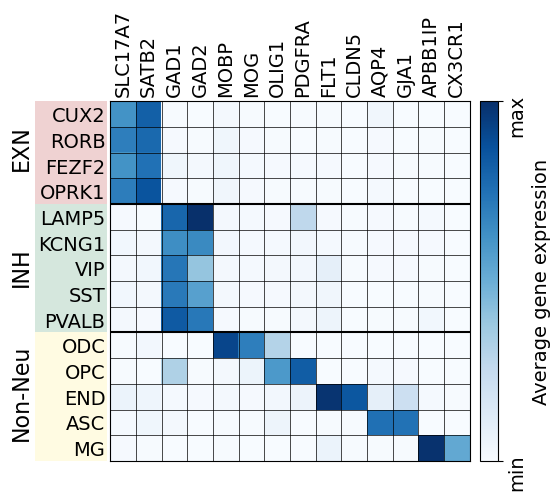

In [8]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['font.size']='14'

fig, ax = plt.subplots(1,1,figsize=(5,5))

p1 = ax.imshow(np.array(df),cmap='Blues')

x_labels = df.columns
y_labels = df.index
ax.set_xticks(np.arange(len(df.columns)),df.columns,rotation=90)
ax.xaxis.tick_top()
ax.set_yticks(np.arange(len(df.index)),['CUX2','RORB','FEZF2','OPRK1','LAMP5','KCNG1','VIP','SST','PVALB',
                                        'ODC','OPC','END','ASC','MG'])

ax.set_xticks(np.arange(-0.5, len(data.obs['subclass_renamed'].unique())-1),minor=True)
ax.set_yticks(np.arange(-0.5, len(genes)-1),minor=True)
ax.grid(which='minor', color='k', linewidth=0.5)
ax.grid(which='major',linewidth=0)
ax.tick_params(axis=u'both', which=u'both',length=0)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
c = plt.colorbar(p1,cax=cax)
c.ax.set_ylabel('Average gene expression')
c.set_ticks([df.min().min(),df.max().max()])
c.set_ticklabels(['min','max'],rotation=90) 

ax.axhline(y=4-0.5,color='k')
ax.axhline(y=9-0.5,color='k')

for x,num,fc,c,y in zip([0,4,9],[4,5,5],['#b22222','#2E8B57','#ffed6f'],['EXN','INH','Non-Neu'],[2,6.5,12.5]):
    rect = plt.Rectangle((-0.21,-0.5+x), width=0.2, height=num,
                     transform=ax.get_yaxis_transform(), clip_on=False,
                     facecolor=fc,alpha=0.2)
    ax.add_patch(rect)
    ax.text(-4.4, y, c,rotation=90,fontsize=16)


#plt.savefig('/home/ah2428/figs/rna_heatmap.pdf',bbox_inches='tight',dpi=300)